# 2022 Alaska Primary  Special General Election


* The results for the 2022 Special General Eleciton in Alaska can be downloaded here [https://www.elections.alaska.gov/election-results/e/?id=22sspg](https://www.elections.alaska.gov/election-results/e/?id=22sspg)

* There were 4 candidates (including Write-Ins) and  192,542 voters: 

    1. Nick Begich ($B$)
    2. Sarah Palin ($P$)
    3. Mary S. Peltola ($M$)
    4. Write-Ins ($W$)
    
* The Ranked Choice winner is Mary S. Peltola. After removing the Write-Ins, Begich loses in the first round leaving Palin in Peltola.  

* Analyses of this election can be found at the following blog posts: 

    * [https://electionscience.org/commentary-analysis/rcv-fools-palin-voters-into-electing-a-progressive-democrat/](https://electionscience.org/commentary-analysis/rcv-fools-palin-voters-into-electing-a-progressive-democrat/).
    * [https://fairvote.org/alaska_rcv_analysis/](https://fairvote.org/alaska_rcv_analysis/)

* One difficulty when converting a CVR file to a profile is rankings is how to truncate a ballot when a voter *overvotes* (places more than two candidates at the same rank).  The rules used to truncate ballots in the Alaska election can be found [here](https://casetext.com/statute/alaska-statutes/title-15-elections/chapter-1515-elections-and-ballots/section-1515350-general-procedure-for-ballot-count?searchWithin=true&listingIndexId=alaska-statutes&q=ranked%20choice%20voting&type=statute&sort=relevance&p=1&tab=keyword&jxs=).  The two key rules are to truncate ballots at the first overvote and truncate ballots if the voter skips two rankings. 

    See [https://github.com/jirin1a/alaska_irv_2022/](https://github.com/jirin1a/alaska_irv_2022/) for another way to process the cvr file. 

* The Condorcet winner was Begich, but was not elected by Ranked Choice

In [1]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
import json
from tqdm.notebook import tqdm

In [2]:
f = open('./edata/alaska_2022/alaska_ranked_choice_2022_cvr.json')
data = json.load(f)

In [3]:

def _truncation(ranking, max_rank, truncate_at_overvote=True, truncate_when_skip = False, truncate_when_skipped_two=False): 
    new_ranking = dict()
    prev_ranked_cand = 0
    for rnk in range(1, max_rank+1):
        cands_at_rank = [c for c in ranking.keys() if ranking[c] == rnk]
        if len(cands_at_rank) == 1: 
            new_ranking[cands_at_rank[0]] = rnk
            prev_ranked_cand = rnk
        elif len(cands_at_rank) == 0:
            if truncate_when_skip: 
                return new_ranking
            if truncate_when_skipped_two and rnk - prev_ranked_cand == 2: 
                return new_ranking
        elif len(cands_at_rank) > 0: 
            if truncate_at_overvote: 
                return new_ranking
            else: 
                for c in cands_at_rank: 
                    new_ranking[c] = rnk
    return new_ranking
    
def process_cvr_data(cvr_data, 
                     election_id, 
                     cmap, 
                     max_rank, 
                     ignore_ambiguous_marks = True, 
                     truncation_type = "simple", 
                     verbose=False): 
    
    truncation_rules = {
        
        "Alaska":  lambda ranking, max_rank: _truncation(ranking, 
                                                         max_rank, 
                                                         truncate_at_overvote=True, 
                                                         truncate_when_skip=False,           
                                                         truncate_when_skipped_two=True),
        
        "San Francisco": lambda ranking, max_rank: _truncation(ranking,  max_rank,   
                                                               truncate_at_overvote=True, 
                                                               truncate_when_skip=False, 
                                                               truncate_when_skipped_two=False),
        
        "simple": lambda ranking, max_rank: _truncation(ranking, 
                                                        max_rank, 
                                                        truncate_at_overvote=False,
                                                        truncate_when_skip=False, 
                                                        truncate_when_skipped_two=False)    
    }
    
    report = {
        "num_ballots_with_ambiguous_marks": 0,
        "num_overvotes": 0,
        "num_ballots_with_skipped_ranks": 0,
        "num_ballots_with_multiple_cand_ranks": 0,
        "num_empty_ballots": 0,
        "num_bullet_votes": 0,
        "num_rank_one": 0,
        "num_truncated_ranking": 0
    }
    num_ambiguous_marks = 0
    rankings = list()
    for c in cvr_data['Contests']:
        if c["Id"] == election_id:
            has_ambiguous_mark = False
            ranking = {}

            if any([int(_m["Rank"]) > 4 for _m in c["Marks"] if not _m["IsAmbiguous"]]): 
                print(c["Marks"])
                print("\n----\n")
            for m in c["Marks"]: 
                if m["IsAmbiguous"]: 
                    has_ambiguous_mark = True
                    num_ambiguous_marks += 1
                    if not ignore_ambiguous_marks: 
                        # check if candidate is double ranked, but ignore write ins (candidate id 214)
                        if m["CandidateId"] != 214 and m["CandidateId"] in ranking.keys(): 
                            report["num_ballots_with_multiple_cand_ranks"] += 1
                            if int(m["Rank"]) < ranking[m["CandidateId"]]: 
                                # keep the highest rank
                                ranking[m["CandidateId"]] = int(m["Rank"])
                        else: 
                            ranking[m["CandidateId"]] = int(m["Rank"])
                else: 
                    # check if candidate is double ranked, but ignore write ins (candidate id 214)
                    if m["CandidateId"] != 214 and m["CandidateId"] in ranking.keys():  
                        report["num_ballots_with_multiple_cand_ranks"] += 1
                        if int(m["Rank"]) < ranking[m["CandidateId"]]: 
                            # keep the highest rank
                            ranking[m["CandidateId"]] = int(m["Rank"])
                    else: 
                        ranking[m["CandidateId"]] = int(m["Rank"])
            if has_ambiguous_mark: 
                report["num_ballots_with_ambiguous_marks"] += 1
            ranks = list(ranking.values())

            if len(ranks) == 0: 
                report["num_empty_ballots"] += 1

            if len(list(set(ranks))) != len(ranks): 
                report["num_overvotes"] += 1

            if len(ranks) > 0 and len(list(set(ranks))) != max(ranks): 
                report["num_ballots_with_skipped_ranks"] += 1

            if ranks == [1]: 
                report["num_bullet_votes"] += 1

            if len(list(set(ranks))) == 1: 
                report["num_rank_one"] += 1

            truncated_ranking = truncation_rules[truncation_type](ranking, max_rank)

            if ranking == truncated_ranking: 
                rankings.append(ranking)
            else: 
                report["num_truncated_ranking"] += 1
                rankings.append(truncated_ranking)
                        
    if verbose: 
        print(f'''The number of ballots: {len(rankings)}
        The number of empty ballots: {report["num_empty_ballots"]}
        The number of ambiguous marks: {num_ambiguous_marks}
        The number of ballots with ambiguous marks: {report["num_ballots_with_ambiguous_marks"]}
        The number of ballots with multiple ranks for a candidate: {report["num_ballots_with_multiple_cand_ranks"]}
        The number of ballots with overvote: {report["num_overvotes"]}
        The number of ballots with a skipped ranking: {report["num_ballots_with_skipped_ranks"]}
        The number of bullet votes: {report["num_bullet_votes"]}
        The number of ballots with one ranking: {report["num_rank_one"]}
        The number of ballots that were truncated: {report["num_truncated_ranking"]}      
        ''')
        
    profile = ProfileWithTies(rankings, cmap=cmap, candidates=sorted(cmap.keys()))
    
    if verbose: 
        print("After processing the ballots:\n")
        profile.report()
    return profile



In [4]:
def display_instant_runoff_results(prof): 
    
    rounds = list()
    
    remaining_candidates = prof.candidates
    
    while len(remaining_candidates) > 1: 
        reduced_prof = prof.remove_candidates([c for c in prof.candidates if c not in remaining_candidates])
        
        pl_scores = reduced_prof.plurality_scores_ignoring_overvotes()
        lowest_pl_score = min(pl_scores.values())
        cands_to_remove = [c for c in pl_scores.keys() if pl_scores[c] == lowest_pl_score]
        
        sorted_pl_scores = sorted(pl_scores.values(), reverse=True)
        sorted_cands = sorted(pl_scores.items(), reverse=True, key=lambda cpl: cpl[1])
        rounds.append('\n'.join([f"\t{prof.cmap[c]} plurality score: {pl_score}" for c, pl_score in sorted_cands]) + '\n' + f'\tThe candidate removed during this round: {reduced_prof.cmap[cands_to_remove[0]]}')
        remaining_candidates = [c for c in remaining_candidates if c not in cands_to_remove]
        
    for ridx, r in enumerate(rounds): 
        print(f"Instant Runoff round {ridx +1}")
        print(r)
        
    print(f"The IRV winner is {prof.cmap[remaining_candidates[0]]}")
    


## Alaska Truncation Rules

Alaska rules for truncating ballots


Ignoring ambiguous marks

The number of ballots: 192289
        The number of empty ballots: 2776
        The number of ambiguous marks: 281
        The number of ballots with ambiguous marks: 173
        The number of ballots with multiple ranks for a candidate: 8899
        The number of ballots with overvote: 661
        The number of ballots with a skipped ranking: 6267
        The number of bullet votes: 51037
        The number of ballots with one ranking: 51612
        The number of ballots that were truncated: 1245      
        
After processing the ballots:

There are 4 candidates and 192289 rankings: 
        The number of empty rankings: 3199
        The number of rankings with ties: 0
        The number of linear orders: 14416
        The number of truncated linear orders: 177873
        The number of rankings with skipped ranks: 8573
        
        
Margin graph using extended strict preference


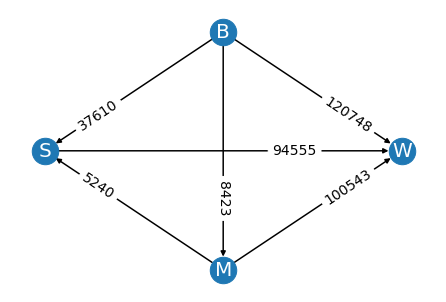

MB 21802
M 20346
MBS 16182
S 20663
BSM 6560
MW 3166
B 10635
BMS 7495
MSB 2554
SB 20840
SBM 10018
 3199
MWBS 2391
SBW 1260
BM 5678
BS 17733
MSWB 68
MS 982
BSWM 510
MBW 2047
BSW 1188
W 503
MBSW 295
MBWS 1917
MWB 2156
WMB 242
WMBS 386
BWS 289
SMBW 77
BMSW 133
WBMS 256
BMW 533
MSBW 78
SMB 2667
MWSB 492
MWS 268
MSW 85
WBSM 178
BW 422
SWB 306
WSB 118
BWSM 203
BMWS 744
SW 483
SBWM 829
SM 583
SBMW 279
BSMW 178
WMSB 98
SWBM 288
BWMS 329
WB 222
WS 104
SWMB 119
SMW 39
WM 225
WSBM 130
WBS 222
BWM 157
WSMB 47
WBM 147
SMWB 68
SWM 32
WMS 22
WSM 23

Do not ignore ambiguous marks

The number of ballots: 192289
        The number of empty ballots: 2773
        The number of ambiguous marks: 281
        The number of ballots with ambiguous marks: 173
        The number of ballots with multiple ranks for a candidate: 9037
        The number of ballots with overvote: 747
        The number of ballots with a skipped ranking: 6299
        The number of bullet votes: 51017
        The number of ballots with o

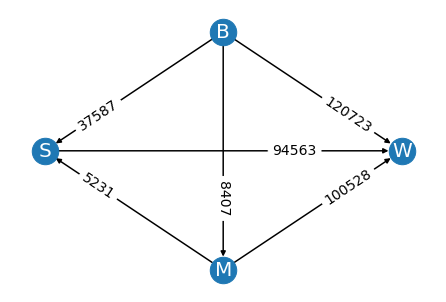

MB 21802
M 20345
MBS 16182
S 20673
BSM 6559
MW 3166
B 10636
BMS 7489
MSB 2554
SB 20827
SBM 10015
 3235
MWBS 2387
SBW 1261
BM 5678
BS 17726
MSWB 68
MS 983
BSWM 510
MBW 2043
BSW 1187
W 503
MBSW 296
MBWS 1913
MWB 2153
WMB 242
WMBS 386
BWS 288
SMBW 77
BMSW 136
WBMS 254
BMW 533
MSBW 78
SMB 2665
MWSB 493
MWS 267
MSW 85
WBSM 178
BW 422
SWB 305
WSB 118
BWSM 203
BMWS 741
SW 483
SBWM 829
SM 584
SBMW 280
BSMW 181
WMSB 98
SWBM 287
BWMS 329
WB 222
WS 104
SWMB 119
SMW 39
WM 225
WSBM 130
WBS 222
BWM 156
WSMB 47
WBM 147
SMWB 68
SWM 32
WMS 22
WSM 23


In [5]:
election_id = 69
cmap = {215: "B", 217:"S", 218: "M", 214: "W"}
max_rank = 4
rc_winner = 218

print("Alaska rules for truncating ballots\n")

print("\nIgnoring ambiguous marks\n")
prof1 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks = True, 
                         truncation_type = "Alaska",
                         verbose=True)


prof1.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof1.display_margin_graph()

prof1.display_rankings()

    
print("\nDo not ignore ambiguous marks\n")

prof2 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks = False, 
                         truncation_type = "Alaska",
                         verbose=True)


prof2.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof2.display_margin_graph()

prof2.display_rankings()



In [ ]:
display_instant_runoff_results(prof2)

In [ ]:
cw = prof2.condorcet_winner()

if cw is None: 
    print("There is no Condorcet winner.")
else: 
    print(f"The Condorcet winner is {cmap[cw]}.")

split_cycle_faster.display(prof2)
stable_voting.display(prof2)
minimax.display(prof2)
beat_path_faster.display(prof2)
copeland.display(prof2)

print()

cl = prof2.condorcet_loser()

if cl is None: 
    print("There is no Condorcet loser.")
else: 
    print(f"The Condorcet loser is {cmap[cl]}.")

In [ ]:
print(f"The IRV winner is {cmap[rc_winner]}")
print(f"The margins of {cmap[rc_winner]} over each other candidate is: ")
for c in prof2.candidates: 
    if c != rc_winner:
        print(f"\tThe margin of {cmap[rc_winner]} over {cmap[c]} is {prof2.margin(rc_winner, c)}")

## Do not truncate ballots

In [ ]:

election_id = 69
cmap = {215: "B", 217:"S", 218: "M", 214: "W"}
max_rank = 4

print("Do not truncate ballots\n")

print("Ignoring ambiguous marks")
prof1 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks = True, 
                         truncation_type = "simple",
                         verbose=True)

prof1.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof1.display_margin_graph()

prof1.display_rankings()
    
print("\nDo not ignore ambiguous marks")

prof2 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks=False, 
                         truncation_type="simple",
                         verbose=True)

prof2.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof2.display_margin_graph()

prof2.display_rankings()



In [ ]:
display_instant_runoff_results(prof2)

In [ ]:
cw = prof2.condorcet_winner()

if cw is None: 
    print("There is no Condorcet winner.")
else: 
    print(f"The Condorcet winner is {cmap[cw]}.")

split_cycle_faster.display(prof2)
stable_voting.display(prof2)
minimax.display(prof2)
beat_path_faster.display(prof2)
copeland.display(prof2)

print()

cl = prof2.condorcet_loser()

if cl is None: 
    print("There is no Condorcet loser.")
else: 
    print(f"The Condorcet loser is {cmap[cl]}.")

In [ ]:
print(f"The IRV winner is {cmap[rc_winner]}")
print(f"The margins of {cmap[rc_winner]} over each other candidate is: ")
for c in prof2.candidates: 
    if c != rc_winner:
        print(f"\tThe margin of {cmap[rc_winner]} over {cmap[c]} is {prof2.margin(rc_winner, c)}")